In [1]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import pandas as pd
import torchvision.models as models 
from torchvision import transforms, utils
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch.optim import lr_scheduler
import seaborn as sns
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import copy
from tqdm import tqdm
#from model import VAE

import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
from dataloader import *
from cnnlstmnetwork import *

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
#only on validation set
csv_path = 'progress.csv'
img_path = '/home/vip/sayan-mandal/datasets/obj_criteria/good_reduced/'

CDL = CNNLSTMDataLoader(csv_path, img_path, transform = transforms.Compose([transforms.Resize(64),transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),timestep=3)

#random sampler
batch_size = 64
validation_split = .2
test_split = .2
train_split = 1-validation_split-test_split
shuffle_dataset = True
random_seed = 42

# Creating data indices for training and validation splits:
dataset_size = len(CDL)
indices = list(range(dataset_size))
split_train = int(np.floor(train_split * dataset_size))
split_valid = int(np.floor((train_split+validation_split) * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices, test_indices =  indices[:split_train],indices[split_train:split_valid],indices[split_valid:]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = torch.utils.data.DataLoader(CDL, batch_size=batch_size, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(CDL, batch_size=batch_size, sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(CDL, batch_size=batch_size, sampler=test_sampler)

In [4]:
tl = iter(train_loader)
dat,_,_ = next(tl)
bs, ts, C, H, W = dat.shape
n_out = 1

model = CNNLSTMNet(channels = C, ts = ts, n_out = n_out, device = device).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,150], gamma= 0.1)
criterion = nn.MSELoss()  # this is for regression mean squared loss

In [5]:
epochs = 200
best_loss =float('inf')
ep, trainloss, validloss, testloss = [],[],[],[]
for epoch in range(1,epochs+1):
    model.train()
    loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=True)
    trloss = 0
    for batch_idx, (data, targets, _) in loop:
        optimizer.zero_grad() 
        data = Variable(data).to(device)
        targets = Variable(targets.to(torch.float).view(targets.shape[0],-1)).to(device)

        #forward pass
        scores = model(data)
        loss = criterion(scores, targets)
        trloss += loss.item()
        #backward pass   
        loss.backward()

        #gradient descent
        optimizer.step()
        loop.set_description(f"Epoch [{epoch}/{epochs}]")
        loop.set_postfix(batch_loss = loss.item(), running_loss = trloss )
    scheduler.step()

    model.eval()
    valloss = 0
    with torch.no_grad():
        for data, targets, _ in valid_loader:
            data = Variable(data).to(device)
            targets = Variable(targets.to(torch.float).view(targets.shape[0],-1)).to(device)

            
            scores = model(data)
            loss = criterion(scores, targets)

            valloss += loss.item()

    if valloss < best_loss:
        tsloss = 0
        with torch.no_grad():
            for data, targets, _ in test_loader:
                data = Variable(data).to(device)
                targets = Variable(targets.to(torch.float).view(targets.shape[0],-1)).to(device)

                
                scores = model(data)
                loss = criterion(scores, targets)

                tsloss += loss.item()
        to_print = "Train Loss: {:.4f} | Valid Loss: {:.4f} ===========> {:.4f} | Test Loss: {:.4f} | Saving model...".format(trloss, best_loss, valloss, tsloss)
        best_loss = valloss
        best_e = epoch
        best_model = copy.deepcopy(model)
    else:
        to_print = "Train Loss: {:.4f} | Valid Loss: {:.4f}".format(trloss, valloss)

    print(to_print)
    ep+=[epoch]
    trainloss += [trloss]
    validloss += [valloss]

Epoch [1/200]: 100%|██████████| 101/101 [00:20<00:00,  4.95it/s, batch_loss=1.9, running_loss=56.7]


Train Loss: 56.7326 | Valid Loss: inf ===========> 17.4122 | Test Loss: 20.0907 | Saving model...


Epoch [2/200]: 100%|██████████| 101/101 [00:20<00:00,  4.96it/s, batch_loss=0.249, running_loss=53.9]


Train Loss: 53.9170 | Valid Loss: 17.4122 ===========> 16.8004 | Test Loss: 19.5829 | Saving model...


Epoch [3/200]: 100%|██████████| 101/101 [00:20<00:00,  4.98it/s, batch_loss=0.242, running_loss=54.1]


Train Loss: 54.0709 | Valid Loss: 16.8004 ===========> 16.7744 | Test Loss: 19.7844 | Saving model...


Epoch [4/200]: 100%|██████████| 101/101 [00:20<00:00,  5.00it/s, batch_loss=0.681, running_loss=54.1]


Train Loss: 54.0832 | Valid Loss: 17.1525


Epoch [5/200]: 100%|██████████| 101/101 [00:20<00:00,  4.98it/s, batch_loss=0.44, running_loss=54]


Train Loss: 54.0007 | Valid Loss: 16.9230


Epoch [6/200]: 100%|██████████| 101/101 [00:20<00:00,  4.93it/s, batch_loss=0.181, running_loss=54.5]


Train Loss: 54.4677 | Valid Loss: 17.0199


Epoch [7/200]: 100%|██████████| 101/101 [00:20<00:00,  4.99it/s, batch_loss=0.38, running_loss=54.6]


Train Loss: 54.6006 | Valid Loss: 16.8209


Epoch [8/200]: 100%|██████████| 101/101 [00:20<00:00,  4.98it/s, batch_loss=0.518, running_loss=54.1]


Train Loss: 54.0928 | Valid Loss: 16.7744 ===========> 16.7535 | Test Loss: 19.4513 | Saving model...


Epoch [9/200]: 100%|██████████| 101/101 [00:20<00:00,  4.98it/s, batch_loss=0.261, running_loss=54.6]


Train Loss: 54.6371 | Valid Loss: 16.8977


Epoch [10/200]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=0.822, running_loss=55.2]


Train Loss: 55.2084 | Valid Loss: 17.0122


Epoch [11/200]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.4, running_loss=54.5]


Train Loss: 54.4588 | Valid Loss: 16.8699


Epoch [12/200]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.287, running_loss=54.2]


Train Loss: 54.2102 | Valid Loss: 18.7684


Epoch [13/200]: 100%|██████████| 101/101 [00:19<00:00,  5.09it/s, batch_loss=0.24, running_loss=53.4]


Train Loss: 53.4232 | Valid Loss: 17.5349


Epoch [14/200]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.357, running_loss=53.7]


Train Loss: 53.7434 | Valid Loss: 17.9794


Epoch [15/200]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.722, running_loss=55.1]


Train Loss: 55.0826 | Valid Loss: 18.7712


Epoch [16/200]: 100%|██████████| 101/101 [00:19<00:00,  5.13it/s, batch_loss=0.417, running_loss=53.3]


Train Loss: 53.3025 | Valid Loss: 16.7535 ===========> 16.4856 | Test Loss: 19.1139 | Saving model...


Epoch [17/200]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=0.416, running_loss=52.3]


Train Loss: 52.2730 | Valid Loss: 18.5601


Epoch [18/200]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.403, running_loss=51.2]


Train Loss: 51.1764 | Valid Loss: 16.4856 ===========> 16.3243 | Test Loss: 19.0930 | Saving model...


Epoch [19/200]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.542, running_loss=50.8]


Train Loss: 50.7738 | Valid Loss: 16.3243 ===========> 16.2354 | Test Loss: 19.0217 | Saving model...


Epoch [20/200]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.269, running_loss=51.3]


Train Loss: 51.3371 | Valid Loss: 16.3908


Epoch [21/200]: 100%|██████████| 101/101 [00:19<00:00,  5.09it/s, batch_loss=0.454, running_loss=51.3]


Train Loss: 51.3025 | Valid Loss: 17.9039


Epoch [22/200]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.244, running_loss=51]


Train Loss: 51.0300 | Valid Loss: 16.2931


Epoch [23/200]: 100%|██████████| 101/101 [00:19<00:00,  5.09it/s, batch_loss=0.794, running_loss=50.4]


Train Loss: 50.4499 | Valid Loss: 16.9186


Epoch [24/200]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.276, running_loss=48.8]


Train Loss: 48.7877 | Valid Loss: 16.7690


Epoch [25/200]: 100%|██████████| 101/101 [00:19<00:00,  5.09it/s, batch_loss=0.282, running_loss=52.4]


Train Loss: 52.4053 | Valid Loss: 18.0628


Epoch [26/200]: 100%|██████████| 101/101 [00:19<00:00,  5.08it/s, batch_loss=0.274, running_loss=52.3]


Train Loss: 52.2639 | Valid Loss: 16.2354 ===========> 16.1538 | Test Loss: 18.3793 | Saving model...


Epoch [27/200]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.422, running_loss=48.5]


Train Loss: 48.5317 | Valid Loss: 16.6762


Epoch [28/200]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.378, running_loss=49.6]


Train Loss: 49.5973 | Valid Loss: 18.0065


Epoch [29/200]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=0.233, running_loss=47.9]


Train Loss: 47.8690 | Valid Loss: 16.7141


Epoch [30/200]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.308, running_loss=47.9]


Train Loss: 47.8687 | Valid Loss: 16.3253


Epoch [31/200]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.263, running_loss=46.1]


Train Loss: 46.0649 | Valid Loss: 16.2974


Epoch [32/200]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.641, running_loss=43.2]


Train Loss: 43.1548 | Valid Loss: 16.1538 ===========> 15.6927 | Test Loss: 18.5502 | Saving model...


Epoch [33/200]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.825, running_loss=49.7]


Train Loss: 49.6624 | Valid Loss: 18.3296


Epoch [34/200]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=1.17, running_loss=49.6]


Train Loss: 49.6482 | Valid Loss: 16.2344


Epoch [35/200]: 100%|██████████| 101/101 [00:19<00:00,  5.13it/s, batch_loss=0.325, running_loss=50]


Train Loss: 49.9640 | Valid Loss: 16.5283


Epoch [36/200]: 100%|██████████| 101/101 [00:19<00:00,  5.08it/s, batch_loss=0.268, running_loss=46.5]


Train Loss: 46.5196 | Valid Loss: 16.2712


Epoch [37/200]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.761, running_loss=48.2]


Train Loss: 48.2237 | Valid Loss: 16.3735


Epoch [38/200]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=0.261, running_loss=44.1]


Train Loss: 44.1262 | Valid Loss: 15.6959


Epoch [39/200]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.225, running_loss=44.7]


Train Loss: 44.6900 | Valid Loss: 16.9617


Epoch [40/200]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=0.295, running_loss=46.9]


Train Loss: 46.9377 | Valid Loss: 16.3390


Epoch [41/200]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.495, running_loss=46.4]


Train Loss: 46.3709 | Valid Loss: 15.6927 ===========> 15.6274 | Test Loss: 17.9289 | Saving model...


Epoch [42/200]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.379, running_loss=42.8]


Train Loss: 42.8466 | Valid Loss: 15.6365


Epoch [43/200]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.118, running_loss=45.8]


Train Loss: 45.7626 | Valid Loss: 18.2608


Epoch [44/200]: 100%|██████████| 101/101 [00:19<00:00,  5.09it/s, batch_loss=0.207, running_loss=51.1]


Train Loss: 51.0846 | Valid Loss: 16.6741


Epoch [45/200]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=0.939, running_loss=42.6]


Train Loss: 42.6041 | Valid Loss: 15.6274 ===========> 15.6139 | Test Loss: 18.0548 | Saving model...


Epoch [46/200]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.678, running_loss=47.2]


Train Loss: 47.1897 | Valid Loss: 16.1906


Epoch [47/200]: 100%|██████████| 101/101 [00:19<00:00,  5.09it/s, batch_loss=0.46, running_loss=43.2]


Train Loss: 43.1936 | Valid Loss: 16.2142


Epoch [48/200]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=0.302, running_loss=45.4]


Train Loss: 45.4163 | Valid Loss: 16.7607


Epoch [49/200]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=0.32, running_loss=40.9]


Train Loss: 40.9348 | Valid Loss: 15.6139 ===========> 15.5269 | Test Loss: 17.9327 | Saving model...


Epoch [50/200]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.618, running_loss=37.6]


Train Loss: 37.6269 | Valid Loss: 16.1844


Epoch [51/200]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.267, running_loss=34.3]


Train Loss: 34.2861 | Valid Loss: 15.5269 ===========> 14.6147 | Test Loss: 16.9166 | Saving model...


Epoch [52/200]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.197, running_loss=31.4]


Train Loss: 31.4283 | Valid Loss: 14.6147 ===========> 14.5044 | Test Loss: 16.9932 | Saving model...


Epoch [53/200]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.662, running_loss=32.3]


Train Loss: 32.2978 | Valid Loss: 15.3966


Epoch [54/200]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.507, running_loss=29.5]


Train Loss: 29.5241 | Valid Loss: 15.6892


Epoch [55/200]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=0.114, running_loss=33]


Train Loss: 32.9555 | Valid Loss: 14.5044 ===========> 14.1039 | Test Loss: 16.4880 | Saving model...


Epoch [56/200]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=0.184, running_loss=32]


Train Loss: 32.0359 | Valid Loss: 14.1039 ===========> 13.9846 | Test Loss: 16.6262 | Saving model...


Epoch [57/200]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=0.416, running_loss=30.4]


Train Loss: 30.3621 | Valid Loss: 13.9846 ===========> 13.8349 | Test Loss: 15.9224 | Saving model...


Epoch [58/200]: 100%|██████████| 101/101 [00:19<00:00,  5.09it/s, batch_loss=0.218, running_loss=24]


Train Loss: 24.0429 | Valid Loss: 13.8349 ===========> 13.7463 | Test Loss: 15.2171 | Saving model...


Epoch [59/200]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.18, running_loss=23]


Train Loss: 23.0380 | Valid Loss: 13.7463 ===========> 13.1184 | Test Loss: 14.9676 | Saving model...


Epoch [60/200]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.148, running_loss=20.4]


Train Loss: 20.4494 | Valid Loss: 13.1184 ===========> 12.8472 | Test Loss: 15.0122 | Saving model...


Epoch [61/200]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.147, running_loss=18.9]


Train Loss: 18.8696 | Valid Loss: 13.5297


Epoch [62/200]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=0.115, running_loss=17.4]


Train Loss: 17.4405 | Valid Loss: 12.8472 ===========> 12.7220 | Test Loss: 14.3929 | Saving model...


Epoch [63/200]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.233, running_loss=16.1]


Train Loss: 16.0770 | Valid Loss: 12.7220 ===========> 12.4522 | Test Loss: 13.5415 | Saving model...


Epoch [64/200]: 100%|██████████| 101/101 [00:19<00:00,  5.08it/s, batch_loss=0.108, running_loss=14.4]


Train Loss: 14.4054 | Valid Loss: 12.4522 ===========> 11.9335 | Test Loss: 13.5589 | Saving model...


Epoch [65/200]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.113, running_loss=12.4]


Train Loss: 12.3913 | Valid Loss: 12.7347


Epoch [66/200]: 100%|██████████| 101/101 [00:19<00:00,  5.09it/s, batch_loss=0.0995, running_loss=12.7]


Train Loss: 12.6583 | Valid Loss: 12.2823


Epoch [67/200]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=0.126, running_loss=10.4]


Train Loss: 10.3661 | Valid Loss: 11.9335 ===========> 11.7895 | Test Loss: 12.3015 | Saving model...


Epoch [68/200]: 100%|██████████| 101/101 [00:19<00:00,  5.09it/s, batch_loss=0.0681, running_loss=9.04]


Train Loss: 9.0429 | Valid Loss: 11.8210


Epoch [69/200]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=0.0524, running_loss=8.45]


Train Loss: 8.4468 | Valid Loss: 11.7895 ===========> 11.0342 | Test Loss: 12.9102 | Saving model...


Epoch [70/200]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.107, running_loss=7.57]


Train Loss: 7.5660 | Valid Loss: 11.7901


Epoch [71/200]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.0602, running_loss=6.76]


Train Loss: 6.7564 | Valid Loss: 12.1183


Epoch [72/200]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.057, running_loss=6.43]


Train Loss: 6.4304 | Valid Loss: 11.0764


Epoch [73/200]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.0662, running_loss=6.09]


Train Loss: 6.0943 | Valid Loss: 11.0342 ===========> 10.7508 | Test Loss: 11.8909 | Saving model...


Epoch [74/200]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=0.0456, running_loss=5.97]


Train Loss: 5.9654 | Valid Loss: 10.7508 ===========> 10.6328 | Test Loss: 11.2109 | Saving model...


Epoch [75/200]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=0.0487, running_loss=5.22]


Train Loss: 5.2202 | Valid Loss: 10.8249


Epoch [76/200]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.0797, running_loss=4.67]


Train Loss: 4.6705 | Valid Loss: 10.6837


Epoch [77/200]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=0.0744, running_loss=4.81]


Train Loss: 4.8069 | Valid Loss: 10.6957


Epoch [78/200]: 100%|██████████| 101/101 [00:19<00:00,  5.09it/s, batch_loss=0.0367, running_loss=4.29]


Train Loss: 4.2911 | Valid Loss: 10.6328 ===========> 10.1507 | Test Loss: 11.6645 | Saving model...


Epoch [79/200]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=0.0602, running_loss=4.09]


Train Loss: 4.0851 | Valid Loss: 10.6033


Epoch [80/200]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=0.0294, running_loss=3.96]


Train Loss: 3.9649 | Valid Loss: 10.7054


Epoch [81/200]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.0351, running_loss=3.67]


Train Loss: 3.6698 | Valid Loss: 10.2955


Epoch [82/200]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=0.0364, running_loss=3.7]


Train Loss: 3.6998 | Valid Loss: 10.1732


Epoch [83/200]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=0.0277, running_loss=3.42]


Train Loss: 3.4225 | Valid Loss: 10.7848


Epoch [84/200]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.0211, running_loss=3.07]


Train Loss: 3.0658 | Valid Loss: 10.6169


Epoch [85/200]: 100%|██████████| 101/101 [00:19<00:00,  5.08it/s, batch_loss=0.0225, running_loss=2.88]


Train Loss: 2.8832 | Valid Loss: 10.3970


Epoch [86/200]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.0642, running_loss=2.84]


Train Loss: 2.8446 | Valid Loss: 10.3540


Epoch [87/200]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.0164, running_loss=3.2]


Train Loss: 3.1979 | Valid Loss: 10.1507 ===========> 9.9541 | Test Loss: 11.4291 | Saving model...


Epoch [88/200]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.0463, running_loss=2.6]


Train Loss: 2.6023 | Valid Loss: 10.1579


Epoch [89/200]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=0.0322, running_loss=2.64]


Train Loss: 2.6356 | Valid Loss: 10.0298


Epoch [90/200]: 100%|██████████| 101/101 [00:19<00:00,  5.08it/s, batch_loss=0.038, running_loss=2.54]


Train Loss: 2.5406 | Valid Loss: 10.1808


Epoch [91/200]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.0398, running_loss=2.48]


Train Loss: 2.4810 | Valid Loss: 10.3485


Epoch [92/200]: 100%|██████████| 101/101 [00:19<00:00,  5.09it/s, batch_loss=0.0362, running_loss=2.48]


Train Loss: 2.4762 | Valid Loss: 10.2085


Epoch [93/200]: 100%|██████████| 101/101 [00:19<00:00,  5.08it/s, batch_loss=0.01, running_loss=2.51]


Train Loss: 2.5062 | Valid Loss: 9.9804


Epoch [94/200]: 100%|██████████| 101/101 [00:19<00:00,  5.09it/s, batch_loss=0.0216, running_loss=2.52]


Train Loss: 2.5174 | Valid Loss: 10.2782


Epoch [95/200]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.0244, running_loss=2.38]


Train Loss: 2.3831 | Valid Loss: 9.9541 ===========> 9.5797 | Test Loss: 10.6965 | Saving model...


Epoch [96/200]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.015, running_loss=2.13]


Train Loss: 2.1286 | Valid Loss: 9.8626


Epoch [97/200]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.0212, running_loss=2.07]


Train Loss: 2.0709 | Valid Loss: 9.8344


Epoch [98/200]: 100%|██████████| 101/101 [00:19<00:00,  5.09it/s, batch_loss=0.0146, running_loss=2.07]


Train Loss: 2.0659 | Valid Loss: 9.9618


Epoch [99/200]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.0183, running_loss=2]


Train Loss: 1.9979 | Valid Loss: 9.8207


Epoch [100/200]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=0.00925, running_loss=1.83]


Train Loss: 1.8266 | Valid Loss: 9.9780


Epoch [101/200]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.0182, running_loss=1.61]


Train Loss: 1.6089 | Valid Loss: 9.7320


Epoch [102/200]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.0196, running_loss=1.51]


Train Loss: 1.5126 | Valid Loss: 9.6500


Epoch [103/200]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=0.0232, running_loss=1.47]


Train Loss: 1.4690 | Valid Loss: 9.6148


Epoch [104/200]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=0.0136, running_loss=1.44]


Train Loss: 1.4384 | Valid Loss: 9.6628


Epoch [105/200]: 100%|██████████| 101/101 [00:19<00:00,  5.08it/s, batch_loss=0.0112, running_loss=1.44]


Train Loss: 1.4384 | Valid Loss: 9.7161


Epoch [106/200]: 100%|██████████| 101/101 [00:19<00:00,  5.09it/s, batch_loss=0.0095, running_loss=1.47]


Train Loss: 1.4705 | Valid Loss: 9.6457


Epoch [107/200]: 100%|██████████| 101/101 [00:19<00:00,  5.09it/s, batch_loss=0.0134, running_loss=1.39]


Train Loss: 1.3901 | Valid Loss: 9.8067


Epoch [108/200]: 100%|██████████| 101/101 [00:19<00:00,  5.09it/s, batch_loss=0.00936, running_loss=1.41]


Train Loss: 1.4109 | Valid Loss: 9.5988


Epoch [109/200]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=0.0151, running_loss=1.33]


Train Loss: 1.3322 | Valid Loss: 9.6706


Epoch [110/200]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.0126, running_loss=1.33]


Train Loss: 1.3271 | Valid Loss: 9.6016


Epoch [111/200]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=0.0179, running_loss=1.32]


Train Loss: 1.3160 | Valid Loss: 9.6906


Epoch [112/200]: 100%|██████████| 101/101 [00:19<00:00,  5.13it/s, batch_loss=0.0144, running_loss=1.36]


Train Loss: 1.3553 | Valid Loss: 10.2100


Epoch [113/200]: 100%|██████████| 101/101 [00:19<00:00,  5.09it/s, batch_loss=0.016, running_loss=1.35]


Train Loss: 1.3467 | Valid Loss: 9.6349


Epoch [114/200]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=0.0367, running_loss=1.36]


Train Loss: 1.3589 | Valid Loss: 9.7385


Epoch [115/200]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.0136, running_loss=1.29]


Train Loss: 1.2902 | Valid Loss: 9.7023


Epoch [116/200]: 100%|██████████| 101/101 [00:19<00:00,  5.08it/s, batch_loss=0.00903, running_loss=1.31]


Train Loss: 1.3098 | Valid Loss: 9.7679


Epoch [117/200]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=0.0134, running_loss=1.35]


Train Loss: 1.3479 | Valid Loss: 9.6360


Epoch [118/200]: 100%|██████████| 101/101 [00:19<00:00,  5.09it/s, batch_loss=0.0102, running_loss=1.27]


Train Loss: 1.2730 | Valid Loss: 9.5797 ===========> 9.5542 | Test Loss: 10.7216 | Saving model...


Epoch [119/200]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=0.0106, running_loss=1.29]


Train Loss: 1.2860 | Valid Loss: 9.6250


Epoch [120/200]: 100%|██████████| 101/101 [00:19<00:00,  5.09it/s, batch_loss=0.00845, running_loss=1.3]


Train Loss: 1.2978 | Valid Loss: 9.6264


Epoch [121/200]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.0198, running_loss=1.23]


Train Loss: 1.2333 | Valid Loss: 9.6214


Epoch [122/200]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=0.0164, running_loss=1.31]


Train Loss: 1.3063 | Valid Loss: 9.7232


Epoch [123/200]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=0.0118, running_loss=1.27]


Train Loss: 1.2721 | Valid Loss: 9.7137


Epoch [124/200]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=0.0098, running_loss=1.3]


Train Loss: 1.2953 | Valid Loss: 9.6542


Epoch [125/200]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=0.0137, running_loss=1.31]


Train Loss: 1.3071 | Valid Loss: 9.5911


Epoch [126/200]: 100%|██████████| 101/101 [00:19<00:00,  5.09it/s, batch_loss=0.0184, running_loss=1.27]


Train Loss: 1.2716 | Valid Loss: 9.7672


Epoch [127/200]: 100%|██████████| 101/101 [00:19<00:00,  5.08it/s, batch_loss=0.0161, running_loss=1.26]


Train Loss: 1.2574 | Valid Loss: 9.6746


Epoch [128/200]: 100%|██████████| 101/101 [00:19<00:00,  5.08it/s, batch_loss=0.0156, running_loss=1.23]


Train Loss: 1.2285 | Valid Loss: 9.7029


Epoch [129/200]: 100%|██████████| 101/101 [00:19<00:00,  5.08it/s, batch_loss=0.00716, running_loss=1.29]


Train Loss: 1.2921 | Valid Loss: 9.6163


Epoch [130/200]: 100%|██████████| 101/101 [00:20<00:00,  4.98it/s, batch_loss=0.0182, running_loss=1.24]


Train Loss: 1.2388 | Valid Loss: 9.9640


Epoch [131/200]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=0.0312, running_loss=1.23]


Train Loss: 1.2309 | Valid Loss: 9.8649


Epoch [132/200]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=0.00628, running_loss=1.2]


Train Loss: 1.1988 | Valid Loss: 9.6786


Epoch [133/200]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.0114, running_loss=1.28]


Train Loss: 1.2760 | Valid Loss: 9.8059


Epoch [134/200]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.00448, running_loss=1.22]


Train Loss: 1.2248 | Valid Loss: 9.6753


Epoch [135/200]: 100%|██████████| 101/101 [00:19<00:00,  5.09it/s, batch_loss=0.0106, running_loss=1.21]


Train Loss: 1.2065 | Valid Loss: 9.7946


Epoch [136/200]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=0.0161, running_loss=1.26]


Train Loss: 1.2558 | Valid Loss: 9.7322


Epoch [137/200]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.0104, running_loss=1.24]


Train Loss: 1.2410 | Valid Loss: 9.6523


Epoch [138/200]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.0215, running_loss=1.19]


Train Loss: 1.1925 | Valid Loss: 9.7287


Epoch [139/200]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=0.0147, running_loss=1.23]


Train Loss: 1.2320 | Valid Loss: 9.6499


Epoch [140/200]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.00726, running_loss=1.15]


Train Loss: 1.1537 | Valid Loss: 9.8537


Epoch [141/200]: 100%|██████████| 101/101 [00:19<00:00,  5.09it/s, batch_loss=0.0106, running_loss=1.21]


Train Loss: 1.2080 | Valid Loss: 9.7596


Epoch [142/200]: 100%|██████████| 101/101 [00:19<00:00,  5.09it/s, batch_loss=0.00796, running_loss=1.2]


Train Loss: 1.1963 | Valid Loss: 9.6847


Epoch [143/200]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.0135, running_loss=1.19]


Train Loss: 1.1868 | Valid Loss: 9.7241


Epoch [144/200]: 100%|██████████| 101/101 [00:19<00:00,  5.09it/s, batch_loss=0.0111, running_loss=1.15]


Train Loss: 1.1542 | Valid Loss: 9.6607


Epoch [145/200]: 100%|██████████| 101/101 [00:19<00:00,  5.09it/s, batch_loss=0.0182, running_loss=1.16]


Train Loss: 1.1647 | Valid Loss: 9.7859


Epoch [146/200]: 100%|██████████| 101/101 [00:19<00:00,  5.09it/s, batch_loss=0.00554, running_loss=1.19]


Train Loss: 1.1901 | Valid Loss: 9.6913


Epoch [147/200]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=0.011, running_loss=1.15]


Train Loss: 1.1463 | Valid Loss: 9.7503


Epoch [148/200]: 100%|██████████| 101/101 [00:19<00:00,  5.09it/s, batch_loss=0.0177, running_loss=1.12]


Train Loss: 1.1179 | Valid Loss: 9.7541


Epoch [149/200]: 100%|██████████| 101/101 [00:19<00:00,  5.13it/s, batch_loss=0.0112, running_loss=1.18]


Train Loss: 1.1782 | Valid Loss: 9.5585


Epoch [150/200]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.0131, running_loss=1.15]


Train Loss: 1.1457 | Valid Loss: 9.5948


Epoch [151/200]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.0205, running_loss=1.15]


Train Loss: 1.1510 | Valid Loss: 9.5948


Epoch [152/200]: 100%|██████████| 101/101 [00:19<00:00,  5.07it/s, batch_loss=0.0112, running_loss=1.15]


Train Loss: 1.1491 | Valid Loss: 9.6883


Epoch [153/200]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.0141, running_loss=1.1]


Train Loss: 1.1039 | Valid Loss: 9.6409


Epoch [154/200]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.00665, running_loss=1.13]


Train Loss: 1.1339 | Valid Loss: 9.6260


Epoch [155/200]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=0.0149, running_loss=1.15]


Train Loss: 1.1472 | Valid Loss: 9.6572


Epoch [156/200]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=0.013, running_loss=1.14]


Train Loss: 1.1390 | Valid Loss: 9.6315


Epoch [157/200]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=0.00668, running_loss=1.11]


Train Loss: 1.1078 | Valid Loss: 9.5757


Epoch [158/200]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=0.00987, running_loss=1.13]


Train Loss: 1.1293 | Valid Loss: 9.7606


Epoch [159/200]: 100%|██████████| 101/101 [00:19<00:00,  5.08it/s, batch_loss=0.0138, running_loss=1.14]


Train Loss: 1.1419 | Valid Loss: 9.6605


Epoch [160/200]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=0.0317, running_loss=1.13]


Train Loss: 1.1340 | Valid Loss: 9.6478


Epoch [161/200]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.0129, running_loss=1.15]


Train Loss: 1.1531 | Valid Loss: 9.6422


Epoch [162/200]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.0177, running_loss=1.15]


Train Loss: 1.1484 | Valid Loss: 9.5743


Epoch [163/200]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.009, running_loss=1.16]


Train Loss: 1.1578 | Valid Loss: 9.5976


Epoch [164/200]: 100%|██████████| 101/101 [00:19<00:00,  5.09it/s, batch_loss=0.0146, running_loss=1.12]


Train Loss: 1.1174 | Valid Loss: 9.8153


Epoch [165/200]: 100%|██████████| 101/101 [00:19<00:00,  5.13it/s, batch_loss=0.0182, running_loss=1.11]


Train Loss: 1.1143 | Valid Loss: 9.5698


Epoch [166/200]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.00879, running_loss=1.12]


Train Loss: 1.1198 | Valid Loss: 9.5834


Epoch [167/200]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.0169, running_loss=1.13]


Train Loss: 1.1331 | Valid Loss: 9.6309


Epoch [168/200]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.0256, running_loss=1.14]


Train Loss: 1.1447 | Valid Loss: 9.8078


Epoch [169/200]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.0149, running_loss=1.14]


Train Loss: 1.1374 | Valid Loss: 9.7898


Epoch [170/200]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=0.0141, running_loss=1.18]


Train Loss: 1.1830 | Valid Loss: 9.6123


Epoch [171/200]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.0118, running_loss=1.1]


Train Loss: 1.1005 | Valid Loss: 9.5771


Epoch [172/200]: 100%|██████████| 101/101 [00:19<00:00,  5.09it/s, batch_loss=0.0193, running_loss=1.11]


Train Loss: 1.1099 | Valid Loss: 9.6289


Epoch [173/200]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.0128, running_loss=1.12]


Train Loss: 1.1169 | Valid Loss: 9.7320


Epoch [174/200]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.00718, running_loss=1.12]


Train Loss: 1.1206 | Valid Loss: 9.6680


Epoch [175/200]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=0.0134, running_loss=1.12]


Train Loss: 1.1232 | Valid Loss: 9.5699


Epoch [176/200]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.0164, running_loss=1.17]


Train Loss: 1.1681 | Valid Loss: 9.7315


Epoch [177/200]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.00902, running_loss=1.12]


Train Loss: 1.1162 | Valid Loss: 9.8123


Epoch [178/200]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=0.00874, running_loss=1.12]


Train Loss: 1.1228 | Valid Loss: 9.6093


Epoch [179/200]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.0145, running_loss=1.11]


Train Loss: 1.1068 | Valid Loss: 9.6300


Epoch [180/200]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.0185, running_loss=1.14]


Train Loss: 1.1447 | Valid Loss: 9.6254


Epoch [181/200]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.0116, running_loss=1.14]


Train Loss: 1.1399 | Valid Loss: 9.6212


Epoch [182/200]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.00651, running_loss=1.18]


Train Loss: 1.1811 | Valid Loss: 9.5599


Epoch [183/200]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.0102, running_loss=1.13]


Train Loss: 1.1331 | Valid Loss: 9.5542 ===========> 9.5477 | Test Loss: 10.5618 | Saving model...


Epoch [184/200]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.019, running_loss=1.12]


Train Loss: 1.1237 | Valid Loss: 9.6636


Epoch [185/200]: 100%|██████████| 101/101 [00:19<00:00,  5.09it/s, batch_loss=0.0176, running_loss=1.16]


Train Loss: 1.1590 | Valid Loss: 9.5785


Epoch [186/200]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.00931, running_loss=1.08]


Train Loss: 1.0804 | Valid Loss: 10.1781


Epoch [187/200]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=0.0136, running_loss=1.12]


Train Loss: 1.1211 | Valid Loss: 9.6312


Epoch [188/200]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=0.0131, running_loss=1.15]


Train Loss: 1.1483 | Valid Loss: 9.6249


Epoch [189/200]: 100%|██████████| 101/101 [00:19<00:00,  5.09it/s, batch_loss=0.0258, running_loss=1.1]


Train Loss: 1.1027 | Valid Loss: 9.6121


Epoch [190/200]: 100%|██████████| 101/101 [00:19<00:00,  5.09it/s, batch_loss=0.0172, running_loss=1.14]


Train Loss: 1.1352 | Valid Loss: 9.6679


Epoch [191/200]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.0516, running_loss=1.17]


Train Loss: 1.1679 | Valid Loss: 9.7020


Epoch [192/200]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=0.0153, running_loss=1.16]


Train Loss: 1.1574 | Valid Loss: 9.6460


Epoch [193/200]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.015, running_loss=1.1]


Train Loss: 1.0979 | Valid Loss: 9.7665


Epoch [194/200]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=0.0107, running_loss=1.09]


Train Loss: 1.0945 | Valid Loss: 9.8554


Epoch [195/200]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.0109, running_loss=1.13]


Train Loss: 1.1321 | Valid Loss: 9.8698


Epoch [196/200]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.0109, running_loss=1.14]


Train Loss: 1.1355 | Valid Loss: 9.9498


Epoch [197/200]: 100%|██████████| 101/101 [00:19<00:00,  5.09it/s, batch_loss=0.0121, running_loss=1.11]


Train Loss: 1.1089 | Valid Loss: 9.6879


Epoch [198/200]: 100%|██████████| 101/101 [00:19<00:00,  5.09it/s, batch_loss=0.0139, running_loss=1.15]


Train Loss: 1.1517 | Valid Loss: 9.7731


Epoch [199/200]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=0.0118, running_loss=1.15]


Train Loss: 1.1504 | Valid Loss: 9.9181


Epoch [200/200]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=0.00879, running_loss=1.17]


Train Loss: 1.1712 | Valid Loss: 9.6665


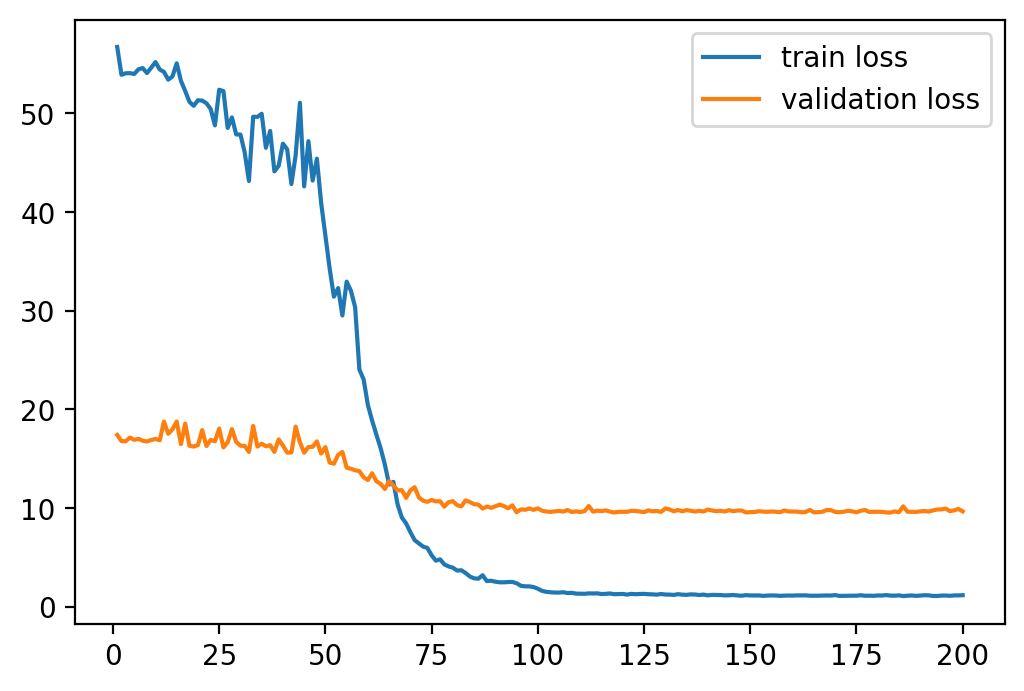

In [6]:
plt.plot(ep,trainloss, label = 'train loss')
plt.plot(ep, validloss, label = 'validation loss')
plt.legend()
plt.show()

In [7]:
tsloss = 0
with torch.no_grad():
    for batch_idx, (data, targets, _) in enumerate(test_loader):
        data = Variable(data).to(device)
        targets = Variable(targets.view(targets.shape[0],-1)).to(device)

        
        scores = best_model(data)
        loss = criterion(scores, targets)

        if batch_idx == 0:
            true_scores = targets.cpu().numpy()
            pred_scores = scores.cpu().numpy()
        else:
            true_scores = np.append(true_scores, targets.cpu().numpy(), axis = 0)
            pred_scores = np.append(pred_scores, scores.cpu().numpy(), axis = 0)


        tsloss += loss.item()

print("Train Loss: {:.4f} | Valid Loss: {:.4f} | Test Loss on Best Model: {:.4f}".format(trloss, valloss, tsloss))


/home/vip/.local/lib/python3.8/site-packages/torch/nn/modules/rnn.py:661: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:915.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


Train Loss: 1.1712 | Valid Loss: 9.6665 | Test Loss on Best Model: 10.9167
